In [55]:
import math
from scipy.stats import norm

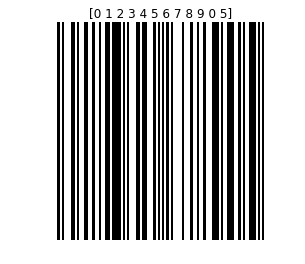

123


In [1]:
%run -i 'generate_barcode.py'
print(np.asarray(stripes).size)

In [20]:
S = len(patterns)
patternLengths = np.zeros(S)
for s in range(S):
    patternLengths[s] = len(patterns[s])
patternLengths = patternLengths.astype(int)

M = 6
C = patternLengths.max().astype(int)
NumStates = C * S * M

# Enumerate all the states
States = (np.zeros((NumStates,3))).astype(int) - 1
StatesInv = (np.zeros((C,S,M))).astype(int) - 1    # ix for a spesific c,s,m
ix = 0
for c in range(1,C+1):
    for s in range(S):
        for m in range(1,M+1):
            if (s>4) or (s<=4 and m==1):
                if c <= patternLengths[s]:
                    States[ix,:] = [c,s,m]
                    StatesInv[c-1,s,m-1] = ix
                    ix += 1
NumStates = ix
States = States[0:NumStates, :]
print(States.shape)
# print(StatesInv[0])

(865, 3)


In [30]:
# Part1: Fill the transition matrix A
# mapping states to binaru numbers, which will be useful for computing the likelihood
# c, m 作为下标时 -1
f_kst = np.zeros(NumStates).astype(int)
A = np.zeros((NumStates,NumStates))

for i in range(NumStates):
    c = States[i,0]
    s = States[i,1]
    m = States[i,2]
    
    patternLen = patternLengths[s]
    f_kst[i] = patterns[s][c-1]    # deternines if this state is black or white
    
    if s==0:    #starting quiet zone
        if c==patternLen:
            for ss in [0,2]:  # The next states can only be either starting quiet zone, or the starting guard
                s_next = ss
                c_next = 1
                m_next = 1
                
                nextStateIx = StatesInv[c_next-1,s_next,m_next-1]
                A[nextStateIx,i] = 1/2
        else:
            c_next = c+1
            s_next = s
            m_next = m
            
            nextStateIx = StatesInv[c_next-1,s_next,m_next-1]
            A[nextStateIx,i] = 1
    elif s==1:    # ending quiet zone
        if c!=patternLen:
            c_next = c+1
            s_next = s
            m_next = m
            nextStateIx = StatesInv[c_next-1,s_next,m_next-1]
            A[nextStateIx,i] = 1
            
    elif s==2:    # starting guard
        if c==patternLen:    # starting the first left digit
            c_next = 1
            m_next = 1
            for ss in range(5,15):
                s_next = ss
                nextStateIx = StatesInv[c_next-1,s_next,m_next-1]
                A[nextStateIx,i] = 1/10
        else:
            c_next = c+1
            s_next = s
            m_next = m
            nextStateIx = StatesInv[c_next-1,s_next,m_next-1]
            A[nextStateIx,i] = 1
            
    elif s==3:    # ending guard
        if c==patternLen:
            s_next = 1
            c_next = 1
            m_next = 1
        else:
            s_next = s
            c_next = c+1
            m_next = m
        nextStateIx = StatesInv[c_next-1,s_next,m_next-1]
        A[nextStateIx,i] = 1
    
    elif s==4:    #middle guard
        if c==patternLen:    # starting the first right digit
            c_next = 1
            m_next = 1
            for ss in range(15,25):
                s_next = ss
                nextStateIx = StatesInv[c_next-1,s_next,m_next-1]
                A[nextStateIx,i] = 1/10
        else:
            c_next = c+1
            s_next = s
            m_next = m
            nextStateIx = StatesInv[c_next-1,s_next,m_next-1]
            A[nextStateIx,i] = 1
    
    elif s in range(5,15):    # left symbols
        if c==patternLen:    
            c_next = 1
            if m==6:    # end of left digits
                s_next = 4
                m_next = 1
                nextStateIx = StatesInv[c_next-1,s_next,m_next-1]
                A[nextStateIx,i] = 1
            else:    # starting the next left digit
                m_next = m+1
                for ss in range(5,15):
                    s_next = ss
                    nextStateIx = StatesInv[c_next-1,s_next,m_next-1]
                    A[nextStateIx,i] = 1/10
        else:
            c_next = c+1
            s_next = s
            m_next = m
            nextStateIx = StatesInv[c_next-1,s_next,m_next-1]
            A[nextStateIx,i] = 1
            
    elif s in range(15,25):    # right symbols
        if c==patternLen:
            c_next = 1
            if m==6:    # end of right digits
                s_next = 3
                m_next = 1
                nextStateIx = StatesInv[c_next-1,s_next,m_next-1]
                A[nextStateIx,i] = 1
            else:    # the next right digit
                m_next = m+1
                for ss in range(15,25):
                    s_next = ss
                    nextStateIx = StatesInv[c_next-1,s_next,m_next-1]
                    A[nextStateIx,i] = 1/10
        else:
            c_next = c+1
            s_next = s
            m_next = m
            nextStateIx = StatesInv[c_next-1,s_next,m_next-1]
            A[nextStateIx,i] = 1

In [44]:
# Part2: Compute the initial probability
p_init = np.zeros((NumStates,NumStates))
# Suppose that the initial probability is a uniform distribution over the
# states with s_n = 0
mask_support_init = States[:, 1] == 0
cnt_support_init = np.sum(mask_support_init)

p_init[mask_support_init] = 1. / cnt_support_init

In [57]:
# Part3: Compute the log-likelihood
T = len(obs)

logObs = np.zeros((NumStates,T))
mu= np.array([250, 20])
sigma = np.array([math.sqrt(5), math.sqrt(5)])

p_state = p_init 

for t in range(0, T):
    # to be filled
    # you can use the variable f_kst here
    logObs = np.log(p_state) + [norm.pdf(obs[t], mu[i], sigma[i]) for i in
            f_kst]
    p_state = A.dot(p_state)

generate_barcode.py:13: RuntimeWarning: divide by zero encountered in log
  chksum = (10 - (3*sum(code[0::2])+sum(code[1::2]))%10) % 10
